In [1]:
import time
import os
import pickle
import numpy as np
import pandas as pd
from typing import Tuple
from collections import deque
import copy
from scipy.special import softmax
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
! git clone "https://github.com/KanghwaSisters/DQN_minesweeper.git"

Cloning into 'DQN_minesweeper'...
remote: Enumerating objects: 9824, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 9824 (delta 8), reused 0 (delta 0), pack-reused 9809 (from 1)
Receiving objects: 100% (9824/9824), 69.07 MiB | 16.63 MiB/s, done.
Resolving deltas: 100% (2658/2658), done.


In [3]:
import os
os.chdir('/content/DQN_minesweeper/codes/Environment')

In [4]:
! python reward5.py
from reward5 import *

In [5]:
env = MinesweeperEnv(map_size=(5,5),
                     n_mines=5,
                     rewards={'win':1, 'lose':-1, 'progress':0.3, 'guess':0.3, 'no_progress' : -1},
                     dones={'win':True, 'lose':True, 'progress':False, 'guess':False, 'no_progress' : False},
                     dim2=False)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
os.chdir('/content/drive/MyDrive/Sabina_Colab/지뢰찾기_프로젝트')
print(os.getcwd())

/content/drive/MyDrive/Sabina_Colab/지뢰찾기_프로젝트


## 시각화 함수

In [8]:
def visualizing(file):
    with open(file, 'rb') as f:
        df = pickle.load(f)

    fig, axs = plt.subplots(3, 4, figsize=(20, 15), squeeze=False)
    axs[0, 0].plot(df['ave_rewards'], color = 'blue')
    axs[0, 0].set_title("Ave Reward")
    axs[0, 1].plot(df['mid_rewards'], color = 'blue')
    axs[0, 1].set_title("Median Reward")
    axs[0, 2].plot(df['rewards'], color = 'blue')
    axs[0, 2].set_title("Reward")

    axs[1, 0].plot(df['ave_count'], color = 'skyblue')
    axs[1, 0].set_title("Ave Cnt")
    axs[1, 1].plot(df['mid_count'], color = 'skyblue')
    axs[1, 1].set_title("Median Cnt")
    axs[1, 2].plot(df['cnt'], color = 'skyblue')
    axs[1, 2].set_title("Cnt")

    axs[2, 0].plot(df['ave_loss'], color = 'green')
    axs[2, 0].set_title("Ave Loss")
    axs[2, 1].plot(df['mid_loss'], color = 'green')
    axs[2, 1].set_title("Median Loss")
    axs[2, 2].plot(df['loss'], color = 'green')
    axs[2, 2].set_title('Loss')

    axs[0, 3].plot(df['ave_clear'], color = 'red')
    axs[0, 3].set_title("Ave Clear")
    axs[1, 3].plot(df['lr'], color = 'grey')
    axs[1, 3].set_title("Learning Rate")

    plt.show()

In [9]:
def test_visualizing(file):
    with open(file, 'rb') as f:
        df = pickle.load(f)

    fig, axs = plt.subplots(2, 4, figsize=(20, 10), squeeze=False)
    axs[0, 0].plot(df['ave_rewards'], color = 'blue')
    axs[0, 0].set_title("Ave Reward")
    axs[0, 1].plot(df['mid_rewards'], color = 'blue')
    axs[0, 1].set_title("Median Reward")
    axs[0, 2].plot(df['rewards'], color = 'blue')
    axs[0, 2].set_title("Reward")

    axs[1, 0].plot(df['ave_count'], color = 'skyblue')
    axs[1, 0].set_title("Ave Cnt")
    axs[1, 1].plot(df['mid_count'], color = 'skyblue')
    axs[1, 1].set_title("Median Cnt")
    axs[1, 2].plot(df['cnt'], color = 'skyblue')
    axs[1, 2].set_title("Cnt")

    axs[0, 3].plot(df['ave_clear'], color = 'red')
    axs[0, 3].set_title("Ave Clear")

    plt.show()

## Net

In [10]:
class Net(nn.Module):
    def __init__(self, state_size, action_size, conv_units):
        super().__init__()
        # 합성곱 층 정의
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=conv_units, kernel_size=(3,3), bias=False, padding=2)

        self.conv2 = nn.Conv2d(in_channels=conv_units, out_channels=conv_units, kernel_size=(3,3), bias=False, padding=1)
        self.bn2 = nn.BatchNorm2d(conv_units)

        self.conv3 = nn.Conv2d(in_channels=conv_units, out_channels=conv_units, kernel_size=(3,3), bias=False, padding=1)
        self.bn3 = nn.BatchNorm2d(conv_units)

        self.conv4 = nn.Conv2d(in_channels=conv_units, out_channels=conv_units, kernel_size=(3,3), bias=False, padding=1)

        self.fc_size = conv_units * (state_size[-1]+2) * (state_size[-2]+2) * state_size[0]
        self.fc = nn.Linear(self.fc_size, action_size)

    def forward(self, x):
        # 순전파
        x = F.relu(self.conv1(x))  # 첫 번째 합성곱층과 활성화 함수 적용 후 풀링
        x = F.relu(self.bn2(self.conv2(x)))  # 두 번째 합성곱층과 활성화 함수 적용
        x = F.relu(self.bn3(self.conv3(x)))  # 세 번째 합성곱층과 활성화 함수 적용
        x = F.relu(self.conv4(x))  # 네 번째 합성곱층과 활성화 함수 적용

        # flatten
        x = x.view(-1, self.fc_size)  # 배치 크기에 맞게 데이터를 평탄화
        # 완전 연결층
        x = self.fc(x)

        return x

## DDQN

In [12]:
class DDQN_Agent:
    def __init__(self, env):
        self.num_mine = env.total_mines
        self.nrow = env.nrows
        self.ncol = env.ncols
        self.state_size = (11, self.nrow, self.ncol)

        self.action_size = env.total_tiles
        self.action = torch.tensor(np.arange(self.action_size))
        self.q_values = torch.zeros(self.action.shape, dtype=torch.float32)

        # 하이퍼파라미터
        self.epsilon = EPSILON
        self.epsilon_decay = EPSILON_DECAY
        self.epsilon_min = EPSILON_MIN
        self.batch_size = BATCH_SIZE
        self.gamma = GAMMA

        # 리플레이 메모리
        self.memory = deque(maxlen = MEM_SIZE)

        # 모델과 타깃 모델 생성
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # model, target model gpu 올리고 초기화
        self.model = Net(self.state_size, self.action_size, CONV_UNITS).to(self.device)
        self.target_model = Net(self.state_size, self.action_size, CONV_UNITS).to(self.device)
        self.update_target_model()
        self.criterion = nn.MSELoss()

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=LEARN_MAX)
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=LEARN_EPOCH, eta_min=LEARN_MIN)

        self.train = False


    def update_target_model(self):
        # 타깃 모델을 업데이트 하는 함수
        self.target_model.load_state_dict(self.model.state_dict())


    def append_sample(self, state, action, reward, next_state, done):
        # 샘플을 리플레이 메모리에 저장하는 함수
        self.memory.append((state, action, reward, next_state, done))


    def get_action(self, state):
        state = torch.tensor(state).to(self.device)

        if (np.random.rand() <= self.epsilon) & self.train:  # 무작위 탐색
            act = int(random.choice(self.action))

        else :
            state = state.to(dtype = torch.float32)
            state = state.unsqueeze(1)
            # 정규화
            # state = state/8

            with torch.no_grad():
                q_values = self.model(state).flatten().to("cpu")
                max_idx = torch.argmax(q_values)
                act = int(max_idx.item())

                self.q_values = q_values

        return act


    def train_model(self):
        # 리플레이 메모리에서 무작위로 추출한 배치로 모델 학습

        # 메모리에서 배치 크기만큼 무작위로 샘플 추출
        batch_size = min(self.batch_size, len(self.memory))
        mini_batch = random.sample(self.memory, batch_size)

        # 상태 정규화 포함
        states = torch.tensor([sample[0] for sample in mini_batch], dtype=torch.float32).to(self.device).reshape(-1,1,self.nrow,self.ncol)
        actions = torch.tensor([sample[1] for sample in mini_batch], dtype=torch.long).to(self.device).reshape(-1,1)
        rewards = torch.tensor([sample[2] for sample in mini_batch], dtype=torch.float32).to(self.device).reshape(-1,1)
        next_states = torch.tensor([sample[3]/8 for sample in mini_batch], dtype=torch.float32).to(self.device).reshape(-1,1,self.nrow,self.ncol)
        dones = torch.tensor([sample[4] for sample in mini_batch], dtype=torch.long).to(self.device).reshape(-1,1)  # bool로 변경
        # clears = torch.tensor([sample[5] for sample in mini_batch], dtype=torch.bool).reshape(-1,1)  # bool로 변경

        # 현재 상태에 대한 모델의 큐함수
        predicts = self.model(states) # 현재 상태의 좌표를 준다
        one_hot_action= F.one_hot(actions, self.action_size).to(self.device)
        predicts = torch.sum(one_hot_action*predicts, axis=1)

        # Q(s,a) 값을 예측값으로 사용 - (batch, action_space.n)
        pred_q_values = self.model(states).gather(1, actions) # action idx의 데이터만 꺼냄

        # target 값 계산 : reward + gamma * Q(s',a')
        with torch.no_grad():
            # next_q_values = self.target_model(next_states).max(1).values.reshape(-1,1)
            next_state_actions = self.model(next_states).max(1).values.unsqueeze(1).to(dtype=torch.int64)
            next_q_values = self.target_model(next_states).gather(1, next_state_actions)
            target_q_values = rewards + (torch.ones(next_q_values.shape, device=self.device) - dones) * self.gamma * next_q_values

        # 오류 함수를 줄이는 방향으로 모델 업데이트
        loss = F.mse_loss(pred_q_values, target_q_values)

        self.optimizer.zero_grad() # 반복 때마다 기울기를 새로 계산해야하므로 기울기 초기화
        loss.requires_grad_(True)
        loss.backward() # 역전파 알고리즘 계산
        self.optimizer.step() # 계산한 기울기를 adam 알고리즘에 맞추어 가중치를 수정

        # 엡실론
        self.epsilon = self.epsilon*self.epsilon_decay
        self.epsilon = max(self.epsilon, self.epsilon_min)

        return loss

## DQN

In [13]:
class DQN_Agent:
    def __init__(self, env):
        self.num_mine = env.total_mines
        self.nrow = env.nrows
        self.ncol = env.ncols
        self.state_size = (11, self.nrow, self.ncol)

        self.action_size = env.total_tiles
        self.action = torch.tensor(np.arange(self.action_size))
        self.q_values = torch.zeros(self.action.shape, dtype=torch.float32)

        # 하이퍼파라미터
        self.epsilon = EPSILON
        self.epsilon_decay = EPSILON_DECAY
        self.epsilon_min = EPSILON_MIN
        self.batch_size = BATCH_SIZE
        self.gamma = GAMMA

        # 리플레이 메모리
        self.memory = deque(maxlen = MEM_SIZE)

        # 모델과 타깃 모델 생성
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # model, target model gpu 올리고 초기화
        self.model = Net(self.state_size, self.action_size, CONV_UNITS).to(self.device)
        self.target_model = Net(self.state_size, self.action_size, CONV_UNITS).to(self.device)
        self.update_target_model()
        self.criterion = nn.MSELoss()

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=LEARN_MAX)
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=LEARN_EPOCH, eta_min=LEARN_MIN)

        self.train = False


    def update_target_model(self):
        # 타깃 모델을 업데이트 하는 함수
        self.target_model.load_state_dict(self.model.state_dict())


    def append_sample(self, state, action, reward, next_state, done):
        # 샘플을 리플레이 메모리에 저장하는 함수
        self.memory.append((state, action, reward, next_state, done))


    def get_action(self, state):
        state = torch.tensor(state).to(self.device)

        if (np.random.rand() <= self.epsilon) & self.train:  # 무작위 탐색
            act = int(random.choice(self.action))

        else :
            state = state.to(dtype = torch.float32)
            state = state.unsqueeze(1)
            # 정규화
            # state = state/8

            with torch.no_grad():
                q_values = self.model(state).flatten().to("cpu")
                max_idx = torch.argmax(q_values)
                act = int(max_idx.item())

                self.q_values = q_values

        return act


    def train_model(self):
        # 리플레이 메모리에서 무작위로 추출한 배치로 모델 학습

        # 메모리에서 배치 크기만큼 무작위로 샘플 추출
        batch_size = min(self.batch_size, len(self.memory))
        mini_batch = random.sample(self.memory, batch_size)

        # 상태 정규화 포함
        states = torch.tensor([sample[0] for sample in mini_batch], dtype=torch.float32).to(self.device).reshape(-1,1,self.nrow,self.ncol)
        actions = torch.tensor([sample[1] for sample in mini_batch], dtype=torch.long).to(self.device).reshape(-1,1)
        rewards = torch.tensor([sample[2] for sample in mini_batch], dtype=torch.float32).to(self.device).reshape(-1,1)
        next_states = torch.tensor([sample[3]/8 for sample in mini_batch], dtype=torch.float32).to(self.device).reshape(-1,1,self.nrow,self.ncol)
        dones = torch.tensor([sample[4] for sample in mini_batch], dtype=torch.long).to(self.device).reshape(-1,1)  # bool로 변경
        # clears = torch.tensor([sample[5] for sample in mini_batch], dtype=torch.bool).reshape(-1,1)  # bool로 변경

        # 현재 상태에 대한 모델의 큐함수
        predicts = self.model(states) # 현재 상태의 좌표를 준다
        one_hot_action= F.one_hot(actions, self.action_size).to(self.device)
        predicts = torch.sum(one_hot_action*predicts, axis=1)

        # Q(s,a) 값을 예측값으로 사용 - (batch, action_space.n)
        pred_q_values = self.model(states).gather(1, actions) # action idx의 데이터만 꺼냄

        # target 값 계산 : reward + gamma * Q(s',a')
        with torch.no_grad():
            # next_q_values = self.target_model(next_states).max(1).values.reshape(-1,1)
            next_q_values = self.target_model(next_states).max(1).values.reshape(-1,1)
            target_q_values = rewards + (torch.ones(next_q_values.shape, device=self.device) - dones) * self.gamma * next_q_values

        # 오류 함수를 줄이는 방향으로 모델 업데이트
        loss = F.mse_loss(pred_q_values, target_q_values)

        self.optimizer.zero_grad() # 반복 때마다 기울기를 새로 계산해야하므로 기울기 초기화
        loss.requires_grad_(True)
        loss.backward() # 역전파 알고리즘 계산
        self.optimizer.step() # 계산한 기울기를 adam 알고리즘에 맞추어 가중치를 수정

        # 엡실론
        self.epsilon = self.epsilon*self.epsilon_decay
        self.epsilon = max(self.epsilon, self.epsilon_min)

        return loss

# Main

## DDQN test 5000

In [15]:
# 파일명
file_name = "ddqn0"

# 하이퍼 파라미터
MEM_SIZE = 20000
MEM_SIZE_MIN = 1000

BATCH_SIZE = 64

LEARN_MAX = 0.001
LEARN_DECAY = 0.99
LEARN_MIN = 0.0001
LEARN_EPOCH = 500

GAMMA = 0.1 #gamma

EPSILON = 0.9999
EPSILON_DECAY = 0.999
EPSILON_MIN = 0.01

# DQN settings
CONV_UNITS = 64
UPDATE_TARGET_EVERY = 5

# grid_size = (9, 9)
# num_mines = 10

PRINT_EVERY = 10
SAVE_EVERY = 500

EPISODES = 5000

# # valid
# VALID_EVERY = 10000
# VALID_NUM = 1000

In [16]:
env = MinesweeperEnv(map_size=(5,5),
                     n_mines=5,
                     rewards={'win':1, 'lose':-1, 'progress':0.3, 'guess':0.3, 'no_progress' : -1},
                     dones={'win':True, 'lose':True, 'progress':False, 'guess':False, 'no_progress' : False},
                     dim2=False)
agent = DDQN_Agent(env)

#######################

rewards_list = []
clear_list = []
cnt_list = []
loss_list = []

ave_rewards_list = []
ave_clear_list = []
ave_count_list = []
ave_loss_list = []

mid_rewards_list = []
mid_clear_list = []
mid_cnt_list = []
mid_loss_list = []

lr_list = []

########### valid
# valid_rewards_list = []
# valid_clear_list = []
# valid_cnt_list = []

# valid_ave_rewards_list = []
# valid_ave_clear_list = []
# valid_ave_cnt_list = []

# valid_mid_rewards_list = []
# valid_mid_clear_list = []
# valid_mid_cnt_list = []

##########################

for episode in range(EPISODES):
    # reset
    env.reset()
    state = env.state.copy()
    done = False
    clear = False
    total_reward = 0
    cnt = 0
    loss = 0
    # agent.action = env.points.copy()
    agent.train = True

    # 게임 종료까지 반복
    while not done:
        cnt+=1

        state = env.state.copy()
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)
        total_reward += reward
        clear = (reward == 1)

        # count 제한: 71
        if cnt > (env.ncols * env.nrows - env.total_mines):
            done = True

        # 리플레이 메모리에 샘플 저장
        # check_18 = env.check_18_up(next_state)
        # if check_18:
        #     agent.append_sample(state, action, reward, next_state, done)
        agent.append_sample(state, action, reward, next_state, done)

        # 학습
        if len(agent.memory) > MEM_SIZE_MIN:
            loss = agent.train_model()
            loss = loss.item()

        if done:
            break

    # 타깃 모델 업데이트
    if episode % UPDATE_TARGET_EVERY == 0:
        agent.update_target_model()

    # lr 조절
    agent.scheduler.step()
    if agent.optimizer.param_groups[0]['lr'] < LEARN_MIN:
        agent.optimizer.param_groups[0]['lr'] = LEARN_MIN

    # 평가지표
    rewards_list.append(total_reward)
    ave_rewards_list.append(np.mean(rewards_list[-PRINT_EVERY*10:]))
    mid_rewards_list.append(np.median(rewards_list[-PRINT_EVERY*10:]))

    clear_list.append(clear)
    ave_clear_list.append(np.mean(clear_list[-PRINT_EVERY*10:]))
    mid_clear_list.append(np.median(clear_list[-PRINT_EVERY*10:]))

    cnt_list.append(cnt)
    ave_count_list.append(np.mean(cnt_list[-PRINT_EVERY*10:]))
    mid_cnt_list.append(np.median(cnt_list[-PRINT_EVERY*10:]))

    loss_list.append(loss)
    ave_loss_list.append(np.mean(loss_list[-PRINT_EVERY*10:]))
    mid_loss_list.append(np.median(loss_list[-PRINT_EVERY*10:]))

    lr_list.append(agent.optimizer.param_groups[0]['lr'])

    if ((episode+1) % SAVE_EVERY == 0) or episode+1 == EPISODES:
        # 리플레이 메모리 저장
        with open(f'{file_name}_memory.pkl', 'wb') as f:
            pickle.dump(agent.memory, f)

        # 모델 저장
        with open(f'{file_name}_model.pkl', 'wb') as f:
            pickle.dump(agent.model.state_dict(), f)

        # 시각화 저장
        df = pd.DataFrame()
        df['rewards'] = rewards_list
        df['ave_rewards'] = ave_rewards_list
        df['mid_rewards'] = mid_rewards_list
        df['clear'] = clear_list
        df['ave_clear'] = ave_clear_list
        df['mid_clear'] = mid_clear_list
        df['cnt'] = cnt_list
        df['ave_count'] = ave_count_list
        df['mid_count'] = mid_cnt_list
        df['loss'] = loss_list
        df['ave_loss'] = ave_loss_list
        df['mid_loss'] = mid_loss_list
        df['lr'] = lr_list

        with open(f'{file_name}_visualizing.pkl', 'wb') as f:
            pickle.dump(df, f)

    if (episode+1) % PRINT_EVERY == 0:
        print(f"[{episode+1}/{EPISODES}]", end=" ")
        print(f"ave clear: {round(np.mean(clear_list[-PRINT_EVERY*10:]), 3)}", end=" | ")
        print(f"cnt: {round(np.mean(cnt_list[-PRINT_EVERY*10:]), 3)}/{round(np.median(cnt_list[-PRINT_EVERY*10:]), 3)}", end=" | ")
        print(f"Reward: {round(np.mean(rewards_list[-PRINT_EVERY*10:]), 3)}/{round(np.median(rewards_list[-PRINT_EVERY*10:]), 3)}", end=" | ")
        print(f"loss: {round(np.mean(loss_list[-PRINT_EVERY*10:]), 3)}/{round(np.median(loss_list[-PRINT_EVERY*10:]),3)}", end=' | ')
        print(f"Epsilon: {round(agent.epsilon, 5)}", end=" | ")
        print(f"lr: {round(agent.optimizer.param_groups[0]['lr'], 5)}")


######################## valid
    # if ((episode+1) % VALID_EVERY == 0) or episode+1 == EPISODES:
    #      # Validation 환경 리셋
    #     validation_env = Environment(grid_size, num_mines)
    #     agent.train = False

    #     for episode in range(VALID_NUM):
    #         # reset
    #         validation_env.reset()
    #         state = validation_env.present_state.copy()
    #         total_reward = 0
    #         cnt = 0
    #         clear = False
    #         done = False

    #         while not done:
    #             cnt += 1
    #             state = validation_env.present_state.copy()
    #             action = agent.get_action(state)
    #             next_state, reward, done, clear = validation_env.step(action)
    #             total_reward += reward

    #             if cnt > (validation_env.ncol * validation_env.nrow - validation_env.num_mine):
    #                 done = True

    #             if done or clear:
    #                 break

    #         valid_rewards_list.append(total_reward)
    #         valid_ave_rewards_list.append(np.mean(valid_rewards_list[-PRINT_EVERY * 10:]))
    #         valid_mid_rewards_list.append(np.median(valid_rewards_list[-PRINT_EVERY * 10:]))

    #         valid_clear_list.append(clear)
    #         valid_ave_clear_list.append(np.mean(valid_clear_list[-PRINT_EVERY * 10:]))
    #         valid_mid_clear_list.append(np.median(valid_clear_list[-PRINT_EVERY * 10:]))

    #         valid_cnt_list.append(cnt)
    #         valid_ave_cnt_list.append(np.mean(valid_cnt_list[-PRINT_EVERY * 10:]))
    #         valid_mid_cnt_list.append(np.median(valid_cnt_list[-PRINT_EVERY * 10:]))

    #     df = pd.DataFrame()
    #     df['rewards'] = valid_rewards_list
    #     df['ave_rewards'] = valid_ave_rewards_list
    #     df['mid_rewards'] = valid_mid_rewards_list
    #     df['clear'] = valid_clear_list
    #     df['ave_clear'] = valid_ave_clear_list
    #     df['mid_clear'] = valid_mid_clear_list
    #     df['cnt'] = valid_cnt_list
    #     df['ave_count'] = valid_ave_cnt_list
    #     df['mid_count'] = valid_mid_cnt_list

    #     with open(f'{file_name}_visualizing_valid.pkl', 'wb') as f:
    #         pickle.dump(df, f)

    #     # print
    #     print("=====valid=====")
    #     print(f"ave clear: {round(np.mean(valid_clear_list[-VALID_NUM:]), 3)}", end=" | ")
    #     print(f"cnt: {round(np.mean(valid_cnt_list[-VALID_NUM:]), 3)}/{round(np.median(valid_cnt_list[-VALID_NUM:]), 3)}", end=" | ")
    #     print(f"Reward: {round(np.mean(valid_rewards_list[-VALID_NUM:]), 3)}/{round(np.median(valid_rewards_list[-VALID_NUM:]), 3)}", end="\n")
    #     print("===============")

print("Training completed.")
visualizing(f"{file_name}_visualizing.pkl")

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


[10/5000] ave clear: 0.0 | cnt: 6.8/4.5 | Reward: -2.9/-1.05 | loss: 0.0/0.0 | Epsilon: 0.9999 | lr: 0.001
[20/5000] ave clear: 0.0 | cnt: 6.2/5.0 | Reward: -2.365/-1.55 | loss: 0.0/0.0 | Epsilon: 0.9999 | lr: 0.001
[30/5000] ave clear: 0.0 | cnt: 6.633/5.0 | Reward: -2.3/-1.7 | loss: 0.0/0.0 | Epsilon: 0.9999 | lr: 0.00099
[40/5000] ave clear: 0.0 | cnt: 6.45/5.0 | Reward: -2.16/-1.55 | loss: 0.0/0.0 | Epsilon: 0.9999 | lr: 0.00099
[50/5000] ave clear: 0.0 | cnt: 5.96/5.0 | Reward: -1.904/-1.05 | loss: 0.0/0.0 | Epsilon: 0.9999 | lr: 0.00098
[60/5000] ave clear: 0.0 | cnt: 5.783/5.0 | Reward: -1.84/-1.05 | loss: 0.0/0.0 | Epsilon: 0.9999 | lr: 0.00097
[70/5000] ave clear: 0.0 | cnt: 6.0/5.0 | Reward: -1.84/-0.7 | loss: 0.0/0.0 | Epsilon: 0.9999 | lr: 0.00096
[80/5000] ave clear: 0.0 | cnt: 5.962/5.0 | Reward: -1.754/-0.75 | loss: 0.0/0.0 | Epsilon: 0.9999 | lr: 0.00094
[90/5000] ave clear: 0.0 | cnt: 5.878/5.0 | Reward: -1.674/-0.7 | loss: 0.0/0.0 | Epsilon: 0.9999 | lr: 0.00093
[100/

<ipython-input-12-4d97233c7f88>:77: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  states = torch.tensor([sample[0] for sample in mini_batch], dtype=torch.float32).to(self.device).reshape(-1,1,self.nrow,self.ncol)


[170/5000] ave clear: 0.01 | cnt: 6.35/5.0 | Reward: -1.793/-0.7 | loss: 0.041/0.0 | Epsilon: 0.94636 | lr: 0.00077
[180/5000] ave clear: 0.01 | cnt: 6.57/5.0 | Reward: -2.026/-0.8 | loss: 0.05/0.0 | Epsilon: 0.87444 | lr: 0.00074
[190/5000] ave clear: 0.01 | cnt: 6.71/5.0 | Reward: -2.179/-1.05 | loss: 0.056/0.0 | Epsilon: 0.81857 | lr: 0.00072
[200/5000] ave clear: 0.01 | cnt: 6.72/5.0 | Reward: -2.176/-0.95 | loss: 0.058/0.0 | Epsilon: 0.77397 | lr: 0.00069
[210/5000] ave clear: 0.01 | cnt: 6.42/5.0 | Reward: -2.123/-0.75 | loss: 0.062/0.0 | Epsilon: 0.74063 | lr: 0.00066
[220/5000] ave clear: 0.0 | cnt: 6.07/4.0 | Reward: -1.754/-0.7 | loss: 0.064/0.021 | Epsilon: 0.70168 | lr: 0.00063
[230/5000] ave clear: 0.01 | cnt: 5.99/4.5 | Reward: -1.654/-0.7 | loss: 0.067/0.024 | Epsilon: 0.66411 | lr: 0.00061
[240/5000] ave clear: 0.01 | cnt: 6.24/5.0 | Reward: -1.683/-0.7 | loss: 0.069/0.025 | Epsilon: 0.62417 | lr: 0.00058
[250/5000] ave clear: 0.01 | cnt: 6.34/5.0 | Reward: -1.679/-0.7 

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


## DQN test 5000

In [21]:
# 파일명
file_name = "dqn0"

# 하이퍼 파라미터
MEM_SIZE = 20000
MEM_SIZE_MIN = 1000

BATCH_SIZE = 64

LEARN_MAX = 0.001
LEARN_DECAY = 0.99
LEARN_MIN = 0.0001
LEARN_EPOCH = 1000

GAMMA = 0.1 #gamma

EPSILON = 0.9999
EPSILON_DECAY = 0.99
EPSILON_MIN = 0.01

# DQN settings
CONV_UNITS = 64
UPDATE_TARGET_EVERY = 5

# grid_size = (9, 9)
# num_mines = 10

PRINT_EVERY = 10
SAVE_EVERY = 500

EPISODES = 5000

# # valid
# VALID_EVERY = 10000
# VALID_NUM = 1000

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


[10/5000] ave clear: 0.0 | cnt: 8.4/7.5 | Reward: -3.07/-2.25 | loss: 0.0/0.0 | Epsilon: 0.9999 | lr: 0.001
[20/5000] ave clear: 0.0 | cnt: 7.3/6.5 | Reward: -2.62/-1.7 | loss: 0.0/0.0 | Epsilon: 0.9999 | lr: 0.001
[30/5000] ave clear: 0.0 | cnt: 7.033/6.0 | Reward: -2.483/-1.15 | loss: 0.0/0.0 | Epsilon: 0.9999 | lr: 0.001
[40/5000] ave clear: 0.0 | cnt: 7.025/6.0 | Reward: -2.508/-1.15 | loss: 0.0/0.0 | Epsilon: 0.9999 | lr: 0.001
[50/5000] ave clear: 0.0 | cnt: 6.46/5.0 | Reward: -2.274/-1.15 | loss: 0.0/0.0 | Epsilon: 0.9999 | lr: 0.001
[60/5000] ave clear: 0.0 | cnt: 6.25/5.0 | Reward: -2.068/-0.9 | loss: 0.0/0.0 | Epsilon: 0.9999 | lr: 0.001
[70/5000] ave clear: 0.0 | cnt: 6.214/5.0 | Reward: -2.073/-1.05 | loss: 0.0/0.0 | Epsilon: 0.9999 | lr: 0.001
[80/5000] ave clear: 0.0 | cnt: 6.188/5.0 | Reward: -1.979/-1.05 | loss: 0.0/0.0 | Epsilon: 0.9999 | lr: 0.001
[90/5000] ave clear: 0.0 | cnt: 6.256/5.0 | Reward: -1.893/-1.05 | loss: 0.0/0.0 | Epsilon: 0.9999 | lr: 0.001
[100/5000] 

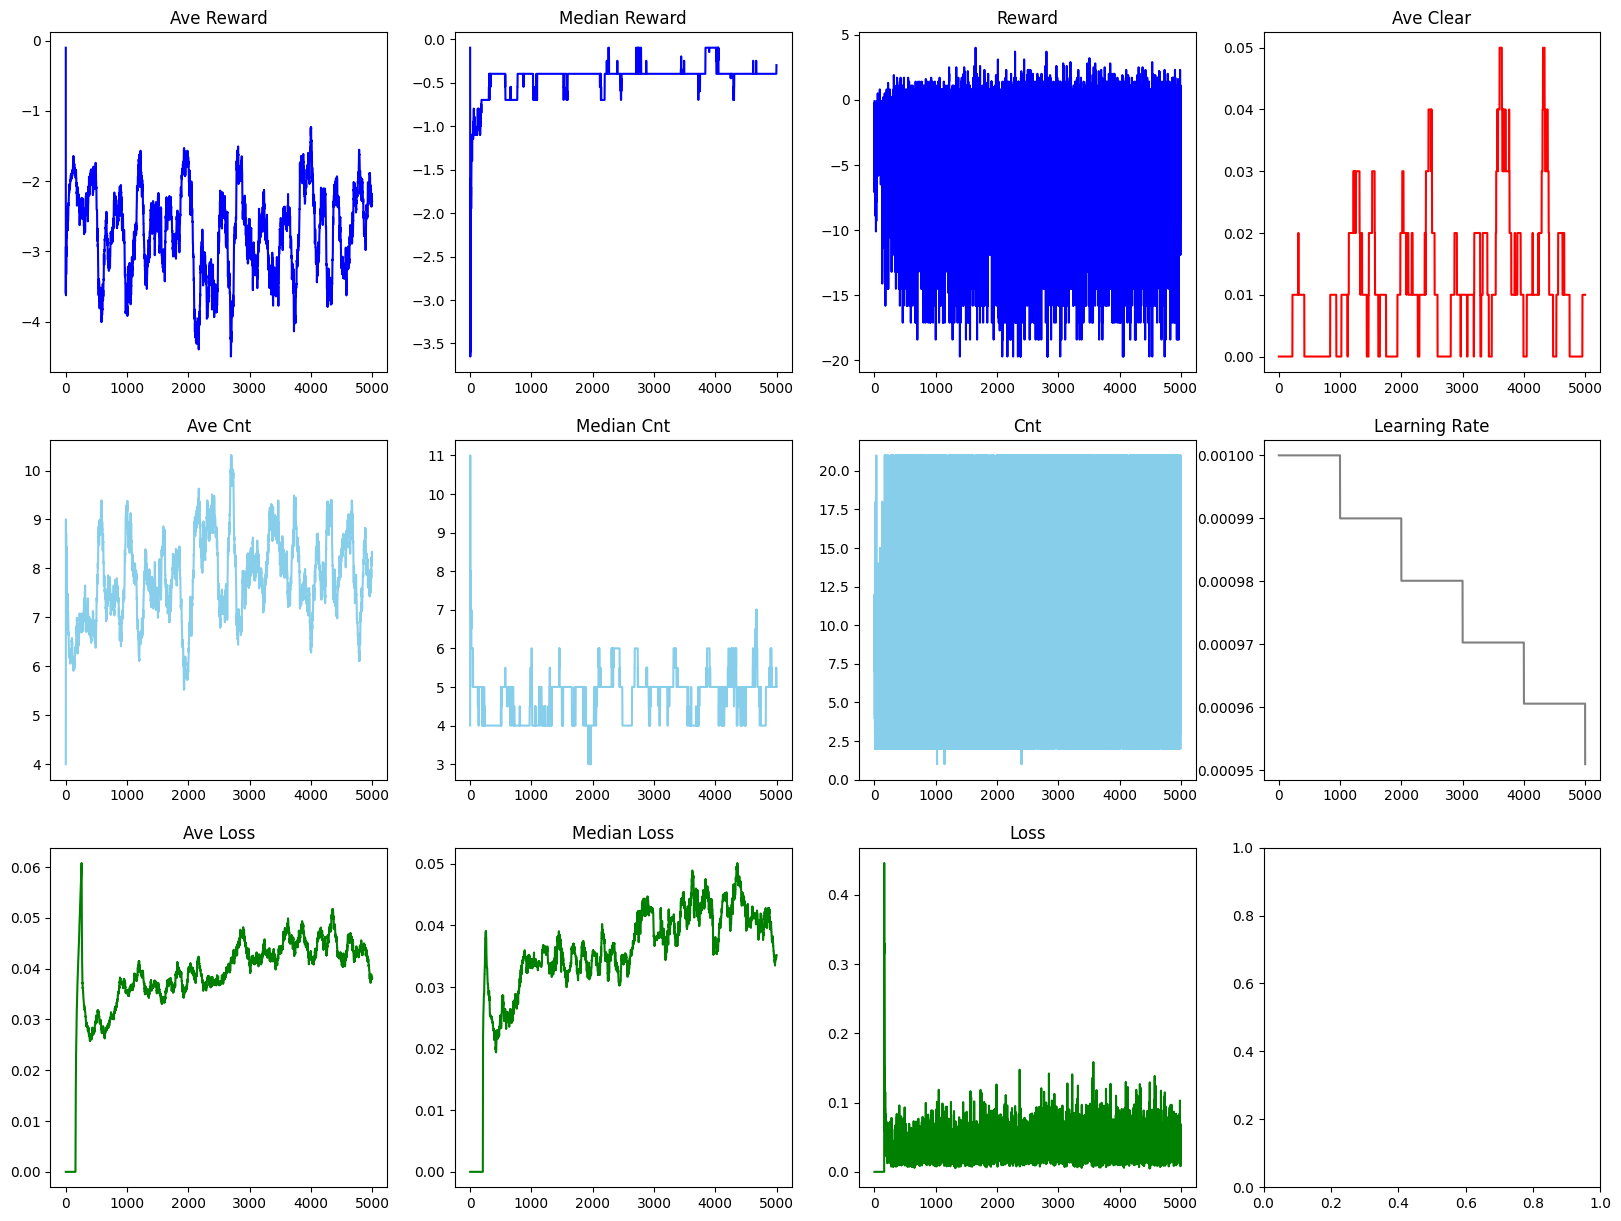

In [22]:
env = MinesweeperEnv(map_size=(5,5),
                     n_mines=5,
                     rewards={'win':1, 'lose':-1, 'progress':0.3, 'guess':0.3, 'no_progress' : -1},
                     dones={'win':True, 'lose':True, 'progress':False, 'guess':False, 'no_progress' : False},
                     dim2=False)
agent = DQN_Agent(env)

#######################

rewards_list = []
clear_list = []
cnt_list = []
loss_list = []

ave_rewards_list = []
ave_clear_list = []
ave_count_list = []
ave_loss_list = []

mid_rewards_list = []
mid_clear_list = []
mid_cnt_list = []
mid_loss_list = []

lr_list = []

########### valid
# valid_rewards_list = []
# valid_clear_list = []
# valid_cnt_list = []

# valid_ave_rewards_list = []
# valid_ave_clear_list = []
# valid_ave_cnt_list = []

# valid_mid_rewards_list = []
# valid_mid_clear_list = []
# valid_mid_cnt_list = []

##########################

for episode in range(EPISODES):
    # reset
    env.reset()
    state = env.state.copy()
    done = False
    clear = False
    total_reward = 0
    cnt = 0
    loss = 0
    # agent.action = env.points.copy()
    agent.train = True

    # 게임 종료까지 반복
    while not done:
        cnt+=1

        state = env.state.copy()
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)
        total_reward += reward
        clear = (reward == 1)

        # count 제한: 71
        if cnt > (env.ncols * env.nrows - env.total_mines):
            done = True

        # 리플레이 메모리에 샘플 저장
        # check_18 = env.check_18_up(next_state)
        # if check_18:
        #     agent.append_sample(state, action, reward, next_state, done)
        agent.append_sample(state, action, reward, next_state, done)

        # 학습
        if len(agent.memory) > MEM_SIZE_MIN:
            loss = agent.train_model()
            loss = loss.item()

        if done:
            break

    # 타깃 모델 업데이트
    if episode % UPDATE_TARGET_EVERY == 0:
        agent.update_target_model()

    # lr 조절
    agent.scheduler.step()
    if agent.optimizer.param_groups[0]['lr'] < LEARN_MIN:
        agent.optimizer.param_groups[0]['lr'] = LEARN_MIN

    # 평가지표
    rewards_list.append(total_reward)
    ave_rewards_list.append(np.mean(rewards_list[-PRINT_EVERY*10:]))
    mid_rewards_list.append(np.median(rewards_list[-PRINT_EVERY*10:]))

    clear_list.append(clear)
    ave_clear_list.append(np.mean(clear_list[-PRINT_EVERY*10:]))
    mid_clear_list.append(np.median(clear_list[-PRINT_EVERY*10:]))

    cnt_list.append(cnt)
    ave_count_list.append(np.mean(cnt_list[-PRINT_EVERY*10:]))
    mid_cnt_list.append(np.median(cnt_list[-PRINT_EVERY*10:]))

    loss_list.append(loss)
    ave_loss_list.append(np.mean(loss_list[-PRINT_EVERY*10:]))
    mid_loss_list.append(np.median(loss_list[-PRINT_EVERY*10:]))

    lr_list.append(agent.optimizer.param_groups[0]['lr'])

    if ((episode+1) % SAVE_EVERY == 0) or episode+1 == EPISODES:
        # 리플레이 메모리 저장
        with open(f'{file_name}_memory.pkl', 'wb') as f:
            pickle.dump(agent.memory, f)

        # 모델 저장
        with open(f'{file_name}_model.pkl', 'wb') as f:
            pickle.dump(agent.model.state_dict(), f)

        # 시각화 저장
        df = pd.DataFrame()
        df['rewards'] = rewards_list
        df['ave_rewards'] = ave_rewards_list
        df['mid_rewards'] = mid_rewards_list
        df['clear'] = clear_list
        df['ave_clear'] = ave_clear_list
        df['mid_clear'] = mid_clear_list
        df['cnt'] = cnt_list
        df['ave_count'] = ave_count_list
        df['mid_count'] = mid_cnt_list
        df['loss'] = loss_list
        df['ave_loss'] = ave_loss_list
        df['mid_loss'] = mid_loss_list
        df['lr'] = lr_list

        with open(f'{file_name}_visualizing.pkl', 'wb') as f:
            pickle.dump(df, f)

    if (episode+1) % PRINT_EVERY == 0:
        print(f"[{episode+1}/{EPISODES}]", end=" ")
        print(f"ave clear: {round(np.mean(clear_list[-PRINT_EVERY*10:]), 3)}", end=" | ")
        print(f"cnt: {round(np.mean(cnt_list[-PRINT_EVERY*10:]), 3)}/{round(np.median(cnt_list[-PRINT_EVERY*10:]), 3)}", end=" | ")
        print(f"Reward: {round(np.mean(rewards_list[-PRINT_EVERY*10:]), 3)}/{round(np.median(rewards_list[-PRINT_EVERY*10:]), 3)}", end=" | ")
        print(f"loss: {round(np.mean(loss_list[-PRINT_EVERY*10:]), 3)}/{round(np.median(loss_list[-PRINT_EVERY*10:]),3)}", end=' | ')
        print(f"Epsilon: {round(agent.epsilon, 5)}", end=" | ")
        print(f"lr: {round(agent.optimizer.param_groups[0]['lr'], 5)}")


######################## valid
    # if ((episode+1) % VALID_EVERY == 0) or episode+1 == EPISODES:
    #      # Validation 환경 리셋
    #     validation_env = Environment(grid_size, num_mines)
    #     agent.train = False

    #     for episode in range(VALID_NUM):
    #         # reset
    #         validation_env.reset()
    #         state = validation_env.present_state.copy()
    #         total_reward = 0
    #         cnt = 0
    #         clear = False
    #         done = False

    #         while not done:
    #             cnt += 1
    #             state = validation_env.present_state.copy()
    #             action = agent.get_action(state)
    #             next_state, reward, done, clear = validation_env.step(action)
    #             total_reward += reward

    #             if cnt > (validation_env.ncol * validation_env.nrow - validation_env.num_mine):
    #                 done = True

    #             if done or clear:
    #                 break

    #         valid_rewards_list.append(total_reward)
    #         valid_ave_rewards_list.append(np.mean(valid_rewards_list[-PRINT_EVERY * 10:]))
    #         valid_mid_rewards_list.append(np.median(valid_rewards_list[-PRINT_EVERY * 10:]))

    #         valid_clear_list.append(clear)
    #         valid_ave_clear_list.append(np.mean(valid_clear_list[-PRINT_EVERY * 10:]))
    #         valid_mid_clear_list.append(np.median(valid_clear_list[-PRINT_EVERY * 10:]))

    #         valid_cnt_list.append(cnt)
    #         valid_ave_cnt_list.append(np.mean(valid_cnt_list[-PRINT_EVERY * 10:]))
    #         valid_mid_cnt_list.append(np.median(valid_cnt_list[-PRINT_EVERY * 10:]))

    #     df = pd.DataFrame()
    #     df['rewards'] = valid_rewards_list
    #     df['ave_rewards'] = valid_ave_rewards_list
    #     df['mid_rewards'] = valid_mid_rewards_list
    #     df['clear'] = valid_clear_list
    #     df['ave_clear'] = valid_ave_clear_list
    #     df['mid_clear'] = valid_mid_clear_list
    #     df['cnt'] = valid_cnt_list
    #     df['ave_count'] = valid_ave_cnt_list
    #     df['mid_count'] = valid_mid_cnt_list

    #     with open(f'{file_name}_visualizing_valid.pkl', 'wb') as f:
    #         pickle.dump(df, f)

    #     # print
    #     print("=====valid=====")
    #     print(f"ave clear: {round(np.mean(valid_clear_list[-VALID_NUM:]), 3)}", end=" | ")
    #     print(f"cnt: {round(np.mean(valid_cnt_list[-VALID_NUM:]), 3)}/{round(np.median(valid_cnt_list[-VALID_NUM:]), 3)}", end=" | ")
    #     print(f"Reward: {round(np.mean(valid_rewards_list[-VALID_NUM:]), 3)}/{round(np.median(valid_rewards_list[-VALID_NUM:]), 3)}", end="\n")
    #     print("===============")

print("Training completed.")
visualizing(f"{file_name}_visualizing.pkl")